In [1]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import geopandas as gpd
import json
import warnings
import time
from os import listdir
from os.path import isfile,join
import datetime
from branca.element import MacroElement
from matplotlib.colors import rgb2hex
from jinja2 import Template
import folium
from branca.colormap import LinearColormap
import matplotlib
import matplotlib.ticker as ticker
import requests
from sklearn.metrics import r2_score
import catboost
import re

In [2]:
def get_covid_data(info='cases'):
    if info == 'cases':
        url = ('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
               'csse_covid_19_time_series/time_series_covid19_confirmed_US.csv').format(sep=2*'\n')
        ren_col = 'Total_cases'
        val_col = 'Daily_cases'
    if info =='deaths':
            url = ('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
                    'csse_covid_19_time_series/time_series_covid19_deaths_US.csv').format(sep=2*'\n')
            ren_col = 'Total_deaths'
            val_col = 'Daily_deaths'
    df = pd.read_csv(url)
    df = df[df['iso3']=='USA']
    df = df.dropna(subset = ['FIPS'])
    df = df[df.FIPS <= 56045]

    df.FIPS = df.FIPS.astype(int).astype(str).str.zfill(5)
    df = df[(df.Admin2 != 'Unassigned' ) & (df.Admin2.notna() )]
    df = df.drop(columns= ['UID','iso2', 'iso3', 'code3','Country_Region','Combined_Key' ])
    date_cols = [col for col in df.columns if '/20' in col]
    id_cols = [col for col in df.columns if col not in date_cols]
    df_gr = df.melt(id_vars=id_cols,value_vars=date_cols)
    df_gr[val_col] = df_gr.groupby(['FIPS'])[['value']].diff().fillna(0)
    df_gr = df_gr.rename(columns = {'value':ren_col, 'variable':'date', 
                                    'Long_':'Lng', 'Admin2':'COUNTY', 
                                   'Province_State': 'STATE', 'FIPS':'fips'})
    df_gr.date = pd.to_datetime( df_gr.date, infer_datetime_format=True)
    df_gr = df_gr.drop(columns = ['STATE', 'COUNTY'])
    return df_gr
    

df_covid_cases = get_covid_data(info='cases')
df_covid_deaths = get_covid_data(info='deaths')[['fips','date','Total_deaths','Daily_deaths']]
df_covid = pd.merge(left = df_covid_cases, right = df_covid_deaths, on = ['fips', 'date'])
df_covid

In [3]:
def weekend(x):
    if x == 'Saturday' or x == 'Sunday':
        return 'Weekend'
    else:
        return 'Weekday'
    

def get_mobility_data(rolling_mean=False):
    mob_index_url = 'https://raw.githubusercontent.com/descarteslabs/DL-COVID-19/master/DL-us-mobility-daterow.csv'
    
    df_mobility_index = pd.read_csv(mob_index_url, parse_dates=['date'])
    df_mobility_index = df_mobility_index.dropna(subset=['fips','admin2'])
    df_mobility_index.fips = df_mobility_index.fips.astype(int)
    df_mobility_index.fips = df_mobility_index.fips.astype(str).str.zfill(5)
    df_mobility_index = df_mobility_index.rename(columns={'admin1':'STATE','admin2':'COUNTY' })
    df_mobility_index = df_mobility_index.drop(columns = ['country_code', 'admin_level'])
    df_mobility_index['weekday'] = df_mobility_index.date.dt.day_name()
    df_mobility_index = df_mobility_index[df_mobility_index.m50<200]
    df_mobility_index['weekend'] = df_mobility_index['weekday'].apply(lambda x: weekend(x))

    if rolling_mean:
        mob_col= ['m50']
        m50 = df_mobility_index.groupby(['fips','date'])[mob_col].mean()
        m50['rolling_mean_mob'] = m50[mob_col].rolling(7,min_periods=1).mean()
        m50 = m50.reset_index()
        return m50
    
    return df_mobility_index

,date,STATE,COUNTY,fips,samples,m50,m50_index,weekday,weekend
130125,2020-05-15,Kentucky,Barren County,21009,1696,7.294,71,Friday,Weekday
375466,2020-05-07,Virginia,Rockingham County,51165,1769,7.347,68,Thursday,Weekday
267272,2020-04-13,Ohio,Lucas County,39095,6391,0.217,3,Monday,Weekday
250282,2020-03-10,North Carolina,Johnston County,37101,4924,16.351,98,Tuesday,Weekday
121637,2020-05-21,Kansas,Cloud County,20029,409,3.605,117,Thursday,Weekday


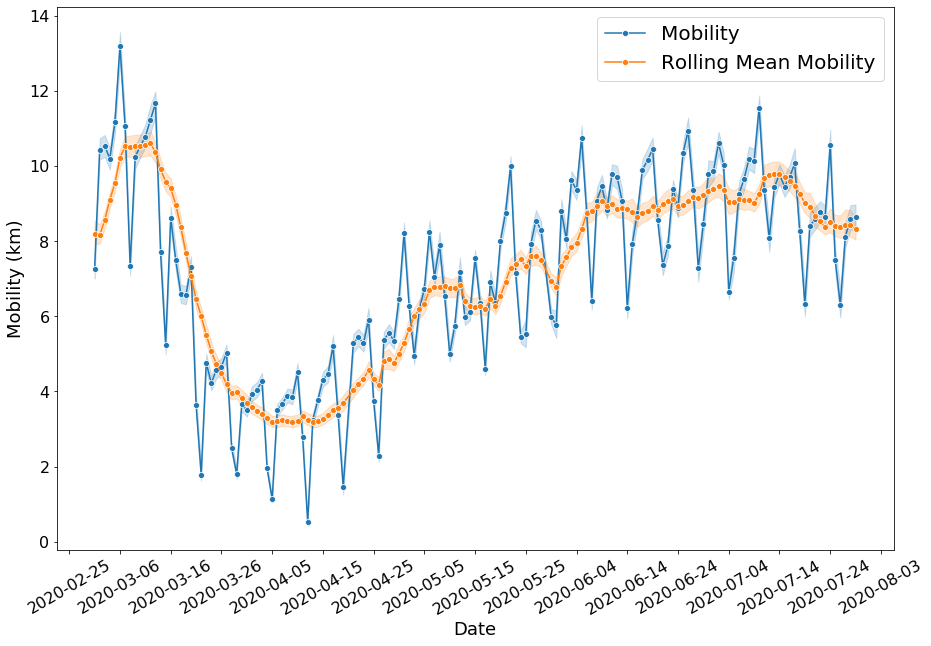

In [5]:
df_mobility = get_mobility_data()
df_mobility_rm = get_mobility_data(rolling_mean=True)
plt.figure(figsize=(15,10))
sns.lineplot(x='date', y = 'm50', data=df_mobility, marker='o',ci=99,label = 'Mobility')
sns.lineplot(x='date', y = 'rolling_mean_mob', data=df_mobility_rm, marker='o',ci=99, label = 'Rolling Mean Mobility')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Mobility (km)', fontsize = 18)
plt.xticks(fontsize=16, rotation=30)
plt.yticks(fontsize=16)
plt.legend(fontsize = 20)
ax=plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
df_mobility.sample(5)

In [6]:
# Splitting mobility dataset before and after covid
df_mobility_pre_covid = df_mobility[df_mobility.date < '2020-03-15']
df_mobility_post_covid = df_mobility[df_mobility.date >= '2020-03-15']
# Mobility by weekday pre and post covid
print('Pre Covid Mobility by Weekday\n',df_mobility_pre_covid.groupby(['weekday'])['m50'].mean().sort_values())
print('\n\nPost Covid Mobility by Weekday\n',df_mobility_post_covid.groupby(['weekday'])['m50'].mean().sort_values())

Pre Covid Mobility by Weekday
 weekday
Sunday        7.305690
Saturday      9.394238
Monday       10.347591
Wednesday    10.487250
Tuesday      10.533296
Thursday     11.195065
Friday       12.436810
Name: m50, dtype: float64


Post Covid Mobility by Weekday
 weekday
Sunday       4.795862
Saturday     6.225984
Monday       6.901068
Tuesday      7.200337
Wednesday    7.405679
Thursday     7.609172
Friday       8.352349
Name: m50, dtype: float64


### Top 5 States with Highest and Lowest Mobility

In [7]:
print('Pre Covid Mobility by State: State with Lowest Mobilities \n',df_mobility_pre_covid.groupby(['STATE'])['m50'].mean().sort_values()[:5])
print('\n\nPost Covid Mobility by State: State with Lowest Mobilities \n',df_mobility_post_covid.groupby(['STATE'])['m50'].mean().sort_values()[:5])

Pre Covid Mobility by State: State with Lowest Mobilities 
 STATE
Alaska        2.746209
Montana       3.978036
Oregon        4.170382
Washington    4.236546
Wyoming       4.313037
Name: m50, dtype: float64


Post Covid Mobility by State: State with Lowest Mobilities 
 STATE
Massachusetts    2.030622
Alaska           2.228731
New Jersey       2.388040
Washington       2.534989
Oregon           2.654302
Name: m50, dtype: float64


In [8]:
print('Pre Covid Mobility by State: State with Highest Mobilities \n',df_mobility_pre_covid.groupby(['STATE'])['m50'].mean().sort_values()[-5:])
print('\n\nPost Covid Mobility by State: State with Highest Mobilities \n',df_mobility_post_covid.groupby(['STATE'])['m50'].mean().sort_values()[-5:])

Pre Covid Mobility by State: State with Highest Mobilities 
 STATE
Georgia        13.446272
Louisiana      13.685572
Texas          14.425607
Alabama        14.507362
Mississippi    14.951344
Name: m50, dtype: float64


Post Covid Mobility by State: State with Highest Mobilities 
 STATE
Oklahoma        9.206883
Arkansas        9.422606
Georgia         9.712367
Mississippi    10.769035
Alabama        10.803565
Name: m50, dtype: float64


In [9]:
# Ranking States by diff between mobility on Friday and mobility on Monday
def get_diff_mob_fri_monday(df,ascending=True):
    df_state_wkday = df.groupby(['STATE','weekday'])['m50'].median().reset_index(level=[1])
    df_state_fri = df_state_wkday[df_state_wkday.weekday=='Friday']
    df_state_mon = df_state_wkday[df_state_wkday.weekday=='Monday']
    return (df_state_fri['m50'] - df_state_mon['m50']).sort_values(ascending=ascending)
    
get_diff_mob_fri_monday(df_mobility_pre_covid)[:5], get_diff_mob_fri_monday(df_mobility_post_covid)[:5]

(STATE
 New Jersey      -0.5195
 Connecticut     -0.1430
 Massachusetts   -0.0040
 Rhode Island     0.0915
 Maryland         0.1505
 Name: m50, dtype: float64,
 STATE
 Colorado      0.3550
 New Mexico    0.4190
 New York      0.4530
 Idaho         0.4545
 New Jersey    0.4675
 Name: m50, dtype: float64)

In [10]:
get_diff_mob_fri_monday(df_mobility_pre_covid,ascending=False)[:5], get_diff_mob_fri_monday(df_mobility_post_covid,ascending=False)[:5]

(STATE
 Kansas      5.3450
 Texas       3.8235
 Iowa        3.6810
 Alabama     3.2450
 Missouri    3.0965
 Name: m50, dtype: float64,
 STATE
 Iowa        2.7180
 Illinois    2.2240
 Texas       2.2220
 Georgia     1.9795
 Alabama     1.8955
 Name: m50, dtype: float64)

In [11]:
df_state_wknd = df_mobility_pre_covid.groupby(['STATE','weekend'])['m50'].median().diff().reset_index()
df_state_wknd[df_state_wknd.weekend == 'Weekend'].sort_values('m50')

,STATE,weekend,m50
71,Oklahoma,Weekend,-4.0130
29,Iowa,Weekend,-3.6990
85,Texas,Weekend,-3.5810
31,Kansas,Weekend,-3.5130
27,Indiana,Weekend,-3.4370
87,Utah,Weekend,-3.3630
69,Ohio,Weekend,-3.3130
39,Maryland,Weekend,-3.3020
35,Louisiana,Weekend,-3.2210
91,Virginia,Weekend,-3.2155


In [12]:
# Importing County Level spending data from https://github.com/Opportunitylab/EconomicTracker

def get_spend_data():
    county_spending_url =  'https://raw.githubusercontent.com/OpportunityInsights/EconomicTracker/main/data/Affinity%20-%20County%20-%20Daily.csv'

    df_county_spending = pd.read_csv(county_spending_url,low_memory=False)

    df_county_spending['date'] = df_county_spending['year'].astype(str) + '-' + \
                                df_county_spending['month'].astype(str) + '-' + \
                                df_county_spending['day'].astype(str)
    df_county_spending.date = pd.to_datetime(df_county_spending.date, infer_datetime_format=True)
    df_county_spending.countyfips = df_county_spending.countyfips.astype(int)
    df_county_spending.countyfips = df_county_spending.countyfips.astype(str).str.zfill(5)
    df_county_spending = df_county_spending.rename(columns={'countyfips':'fips'})
    print(df_county_spending.fips.nunique())
    df_county_spending.spend_all = df_county_spending.spend_all.str.replace('.','0.')
    df_county_spending.spend_all =df_county_spending.spend_all.astype(float)
    return df_county_spending

In [13]:
df_county_spending = get_spend_data()
df_county_spending

1767


,year,month,day,fips,spend_all,date
0,2020,1,6,01001,0.0000,2020-01-06
1,2020,1,6,01003,0.0000,2020-01-06
2,2020,1,6,01009,0.0000,2020-01-06
3,2020,1,6,01015,0.0000,2020-01-06
4,2020,1,6,01019,0.0000,2020-01-06
...,...,...,...,...,...,...
346327,2020,7,19,56035,0.0294,2020-07-19
346328,2020,7,19,56037,-0.0610,2020-07-19
346329,2020,7,19,56039,-0.3370,2020-07-19
346330,2020,7,19,56041,-0.0439,2020-07-19


### County Spend / Mobility vs Date

(737485.0, 737634.0)

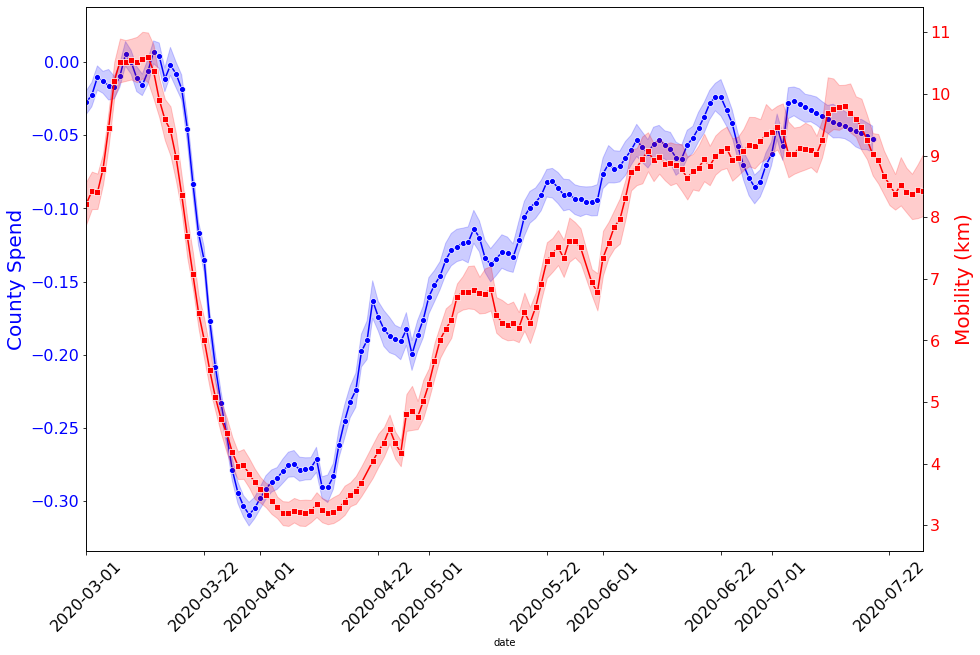

In [14]:
plt.figure(figsize=(15,10))
ax = sns.lineplot(x='date', y = 'spend_all', data=df_county_spending, marker='o',ci=100,color='blue')
plt.ylabel('County Spend', color='blue', fontsize=20)
plt.xticks(fontsize=16,rotation=45)
plt.yticks(fontsize=16,color='blue')
ax2 = ax.twinx()
sns.lineplot(x='date', y = 'rolling_mean_mob', data=df_mobility_rm, marker='s',ci=100, ax =ax2, color = 'red')
plt.ylabel('Mobility (km)',color='red', fontsize=20)
plt.yticks(fontsize=16,color='red')
plt.xlim(df_mobility_rm.date.min(), df_mobility_rm.date.max())

In [15]:
def get_covid_rates():
    case_url = 'https://github.com/OpportunityInsights/EconomicTracker/blob/main/data/COVID%20Cases%20-%20County%20-%20Daily.csv?raw=true'
    death_url = 'https://github.com/OpportunityInsights/EconomicTracker/blob/main/data/COVID%20Deaths%20-%20County%20-%20Daily.csv?raw=true'
    df_covid_case_rate = pd.read_csv(case_url,low_memory=False)
    df_covid_death_rate = pd.read_csv(death_url,low_memory=False)
    df_covid_rate = pd.DataFrame()
    for df in [df_covid_case_rate,df_covid_death_rate]:
        df['date'] = df['year'].astype(str) + '-' + \
                            df['month'].astype(str) + '-' + \
                            df['day'].astype(str)
        df.date = pd.to_datetime(df.date, infer_datetime_format=True)
        df.countyfips = df.countyfips.astype(int)
        df.countyfips = df.countyfips.astype(str).str.zfill(5)
        df = df.rename(columns={'countyfips':'fips'})
        df = df.drop(columns=['month','day','year'])
        cols = list(df.columns[1:3])
        if 'death_rate' in cols:
            
            df = df.drop(columns=['fips','date'])
        for col in cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].fillna(0)
        df_covid_rate = pd.concat([df_covid_rate,df], axis =1)
    return df_covid_rate
    

In [18]:
df_covid_cases = get_covid_data(info='cases')
df_covid_deaths = get_covid_data(info='deaths')[['fips','date','Total_deaths','Daily_deaths']]
df_covid_merged = pd.merge(left = df_covid_cases, right = df_covid_deaths, on = ['fips', 'date'])
df_covid_rate = get_covid_rates()
df_covid = pd.merge(left = df_covid_merged, right = df_covid_rate, on = ['fips', 'date'], how='outer')
df_covid

,fips,Lat,Lng,date,Total_cases,Daily_cases,Total_deaths,Daily_deaths,case_rate,new_case_rate,death_rate,new_death_rate
0,01001,32.539527,-86.644082,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,01003,30.727750,-87.722071,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,01005,31.868263,-85.387129,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,01007,32.996421,-87.125115,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,01009,33.982109,-86.567906,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
603259,56037,NaN,NaN,2020-01-21,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
603260,56039,NaN,NaN,2020-01-21,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
603261,56041,NaN,NaN,2020-01-21,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
603262,56043,NaN,NaN,2020-01-21,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0


#df_covid = pd.merge(left = df_covid, right = df_covid_rate, on = ['fips', 'date'], how='outer')
df_mob_covid = pd.merge(left = df_mobility, right = df_covid, on = ['fips', 'date'], how='outer')
#df_mob_covid['Weekday'] = df_mob_covid.date.dt.day_name()
#df_mob_covid = df_mob_covid.dropna(subset=['Lat'])
#fips_lat_lng = df_mob_covid[['fips','Lat','Lng']].drop_duplicates().set_index('fips').to_dict('index')
df_mob_covid

In [19]:
# Get API keys from config file
def get_weather_chunk(lat,lng,start_dt, end_dt,API_KEY):
    
    url = 'https://api.worldweatheronline.com/premium/v1/past-weather.ashx'
    query = '?q=' + str(lat) + ','+str(lng)
    key = '&key=' + API_KEY
    ret_format = '&format=json'
    sdate = '&enddate='+ start_dt
    edate = '&date=' + end_dt
    tp = '&tp=24'
    final_url = url + query + ret_format +  edate + sdate + tp + key
    get_weather = requests.get(final_url)
    weather_data = json.loads(get_weather.text)
   
    return weather_data

def get_weather_data(lat,lng, start_date,end_date,fips,key_count):
    new_low = datetime.datetime.strptime(end_date, '%Y-%m-%d')
    new_end = datetime.timedelta(days=34) + new_low
    final_end = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    df = pd.DataFrame()
    API_KEYS = API_KEY_LIST
    last=False
    API_KEY=API_KEYS[key_count]
    if final_end-new_low <datetime.timedelta(days=34):
        weather_data = get_weather_chunk(lat,lng,start_date, end_date,API_KEY)
        df = pd.DataFrame(weather_data['data']['weather'])
        last = True
    while(last==False):
        if new_end <final_end:
            
            end_dt = datetime.datetime.strftime(new_low,'%Y-%m-%d' )
            start_dt = datetime.datetime.strftime(new_end,'%Y-%m-%d' )
            
            weather_data = get_weather_chunk(lat,lng,start_dt, end_dt,API_KEY)
            while( 'error' in weather_data['data']):
                
                print('Error', API_KEY)
                    
            
                key_count+=1
                if key_count == len(API_KEYS):
                    raise Exception('Out of API Keys')
                API_KEY=API_KEYS[key_count]
                weather_data = get_weather_chunk(lat,lng,start_dt, end_dt,API_KEY)
            df_weather_chunk = pd.DataFrame(weather_data['data']['weather'])
            df = pd.concat([df,df_weather_chunk], ignore_index=True)
            new_low = new_end + datetime.timedelta(days=1)
            last_itr = new_end
            new_end = datetime.timedelta(days=34) + new_low

           
        else:
            new_low = last_itr + datetime.timedelta(days=1)
            new_end = final_end
            end_dt = datetime.datetime.strftime(new_low,'%Y-%m-%d' )
            start_dt = datetime.datetime.strftime(new_end,'%Y-%m-%d' )
            weather_data = get_weather_chunk(lat,lng,start_dt, end_dt,API_KEY)
            df_weather_chunk = pd.DataFrame(weather_data['data']['weather'])
            df = pd.concat([df,df_weather_chunk], ignore_index=True)
            last = True

    df = df.drop(columns=['uvIndex'])
    df_h = pd.DataFrame()
    
    for val in df['hourly'].values:
        df_h = pd.concat([df_h, pd.DataFrame(val)], ignore_index=True)
    
    df = pd.concat([df, df_h], axis=1)
    use_cols = ['date','tempC', 'maxtempC', 'mintempC','WindChillC','FeelsLikeC', 'visibilityMiles','HeatIndexC', 
            'avgtempC', 'windspeedMiles', 'winddirDegree','pressure', 'WindGustMiles','precipMM',
            'totalSnow_cm' , 'sunHour', 'DewPointC','humidity','uvIndex']
    df = df[use_cols]
    cols= [col for col in df.columns if col!='date']
    df= df.apply(pd.to_numeric, errors='ignore')
    df.date = pd.to_datetime(df.date, infer_datetime_format=True)
    df['fips'] = fips
    return df,key_count

In [20]:
start_date = datetime.datetime.strftime(df_mob_covid.date.max(), '%Y-%m-%d')
end_date =  datetime.datetime.strftime(df_mob_covid.date.min(), '%Y-%m-%d')

fpath1 = './Data/Weather_Files/'
os.makedirs(fpath1, exist_ok=True)
files_all = [fpath1+f for f in listdir(fpath1) if isfile(join(fpath1, f))]
weather_files = [f for f in files_all if 'Weather' in f]
fips_done = [file.split('_')[3].split('.csv')[0] for file in weather_files]
key_count = 0
for fips,lat_lng in list(fips_lat_lng.items()):
    if fips in fips_done:
        weather_df_fips = pd.read_csv(fpath1 + 'Weather_FIPS_'+str(fips)+'.csv',parse_dates=['date'])
        if weather_df_fips.date.max() >= df_mob_covid.date.max():
            continue
        else:
            end_date = datetime.datetime.strftime(weather_df_fips.date.max()+datetime.timedelta(days=1),format='%Y-%m-%d') 
            start_date =datetime.datetime.strftime( df_mob_covid.date.max(),format='%Y-%m-%d') 
        
    
        
    lat,lng = lat_lng['Lat'],lat_lng['Lng']
    weather_df,key_count = get_weather_data(lat,lng, start_date,end_date,fips,key_count)
    weather_df = pd.concat([weather_df_fips,weather_df], ignore_index=True, axis=0)
    weather_df.to_csv(fpath1 + 'Weather_FIPS_'+str(fips)+'.csv',index=False)

NameError: name 'df_mob_covid' is not defined

In [ ]:
def get_weather(start_date):
    fpath = './Data/All_County_Weather_'+start_date+'.csv'
    if os.path.exists(fpath):
        df_weather = pd.read_csv(fpath, parse_dates=['date'])
    else:
        fpath1 = './Data/Weather_Files/'
        files_all = [fpath1+f for f in listdir(fpath1) if isfile(join(fpath1, f))]
        weather_files = [f for f in files_all if 'Weather' in f]
        fips_done = [file.split('_')[3].split('.csv')[0] for file in weather_files]

        df_weather = pd.DataFrame()
        i=0
        for file in weather_files:
            df = pd.read_csv(file)
            df_weather = pd.concat([df_weather,df], ignore_index=True)
            i+=1
            if i%500 == 0:
                print('Finised Records = ', i)
        df_weather.date = pd.to_datetime(df_weather.date, infer_datetime_format=True)
        df_weather.to_csv('./Data/All_County_Weather_'+start_date+'.csv', index=False)
    df_weather.fips = df_weather.fips.astype(str).str.zfill(5)
    return df_weather
df_weather = get_weather(start_date)
df_weather

df_mob_covid_weather = pd.merge(left = df_mob_covid, right = df_weather, on =['date', 'fips'])
df_mob_covid_weather

In [ ]:
df_county = pd.read_csv('./Data/nhgis0010_ds239_20185_2018_county.csv', encoding='latin')
df_county['fips'] = df_county.STATEA.astype(str).str.zfill(2)+df_county.COUNTYA.astype(str).str.zfill(3)
df_gini_income = pd.read_csv('./Data/nhgis0010_ds240_20185_2018_county.csv', encoding='latin')
df_gini_income = df_gini_income[['STATE', 'COUNTY', 'AKGVE001']]
df_county_demo = pd.merge(left = df_county , right = df_gini_income, on =['STATE', 'COUNTY'])
cols_A = df_county_demo.columns[df_county_demo.columns.str.endswith('A')]
margin_cols = [col for col in df_county_demo.columns if 'M' in col[4:5]]

df_county_demo = df_county_demo.drop(columns = ['GISJOIN']+list(cols_A) + margin_cols )
df_county_demo.head(2)

In [ ]:
f = open('./Data/nhgis0010_ds239_20185_2018_county_codebook.txt','r') 
searchlines = f.readlines()
f.close()
for i in range(len(searchlines)):
    if '    Margins of error' in searchlines[i] :
        error_margin = i
col_dict={}
for col in df_county_demo.columns[4:]:
    for i, line in enumerate(searchlines):
        #print(i)
        if col[:-4] in line and 'Table' in searchlines[i-3] and i <error_margin :
            text = re.sub(r"\s+", " ", searchlines[i-3].strip())
            top_col = text.split(':')[1].strip()
        if col in line:
            text = line.strip().split(':')[1:]
            col_name = ''.join(map(str, text))
            col_name = re.sub(r"\s+", " ", col_name).strip()
            #print(col_name)
            col_dict[col] = top_col+ '_' + col_name
        
df_county_demo = df_county_demo.rename(columns=col_dict)
insurance_cols = [col for col in df_county_demo.columns if 'Insurance' in col]
hispanic_cols = [col for col in df_county_demo.columns if 'Hispanic' in col]

df_county_demo = df_county_demo.drop(columns=insurance_cols+hispanic_cols)
df_county_demo.head(2)

In [ ]:
county_election = pd.read_csv('./Data/countypres_2000-2016.csv', sep = '\t')
county_election = county_election[county_election.year ==2016]
maj_party = county_election['party'][county_election.groupby('FIPS')['candidatevotes'].idxmax()]
fips = county_election['FIPS'][county_election.groupby('FIPS')['candidatevotes'].idxmax()]
fips_party = pd.concat([fips,maj_party], ignore_index=False,axis=1,).reset_index(drop=True).dropna()
fips_idx_county = county_election.set_index('FIPS')
pct_rep = (fips_idx_county[fips_idx_county['party']=='republican']['candidatevotes'])/ \
            (fips_idx_county[fips_idx_county['party']=='republican']['candidatevotes']+fips_idx_county[fips_idx_county['party']=='democrat']['candidatevotes'])
pct_rep = pct_rep.reset_index().rename(columns={'candidatevotes': 'pct_republican'})
fips_party = fips_party.join(pct_rep.set_index('FIPS'), on = 'FIPS')
fips_party.FIPS = fips_party.FIPS.astype(int).astype(str).str.zfill(5)
fips_party

In [ ]:
total_cols = [col for col in df_county_demo.columns if 'Total' in col]
for col in total_cols:
    remaining_cols = [c for c in list(df_county_demo.columns) if c!=col]
    for df_col in remaining_cols:
        if col.split('_')[0] in df_col:
            df_county_demo[df_col] = df_county_demo[df_col]/df_county_demo[col]
df_county_demo = df_county_demo.join(fips_party.set_index('FIPS'), on = 'fips')  
df_county_demo = df_county_demo.fillna(df_county_demo.mean())
df_county_demo.isna().sum()

In [ ]:
def get_model_df(df_weather, df_mob,df_covid,df_demographics):
    df_mob_covid = pd.merge(left = df_mob, right = df_covid, on = ['fips', 'date'], how='outer')
    df_mob_covid = df_mob_covid.dropna(subset=['Lat'])
    df_mob_covid_weather = pd.merge(left = df_mob_covid, right = df_weather, on =['date', 'fips'])
    df_all = pd.merge(left = df_mob_covid_weather.drop(columns=['STATE', 'COUNTY']), right = df_demographics, on = ['fips'])
    # Removing the dates before March 1 for mobility predictions
    df_all_mob = df_all[(df_all.date >= df_mobility.date.min()) 
                                                & (df_all.date <= df_mobility.date.max())]

    #Eventual Test data for which we do not have mobility values
    df_mob_null = df_all_mob.mask(df_all_mob.isnull())
    # Defining the training dataset
    df_mob_train = df_all_mob.dropna()
    return df_mob_train

In [ ]:
df_mob_train = def get_model_df(df_weather, df_mobility,df_covid,df_county_demo)


df_all = pd.merge(left = df_mob_covid_weather.drop(columns=['STATE', 'COUNTY']), right = df_county_demo, on = ['fips'])
# Removing the dates before March 1 for mobility predictions
df_all_mob = df_all[(df_all.date >= df_mobility.date.min()) 
                                            & (df_all.date <= df_mobility.date.max())]

#Eventual Test data for which we do not have mobility values
df_mob_null = df_all_mob.mask(df_all_mob.isnull())
# Defining the training dataset
df_mob_train = df_all_mob.dropna()
df_mob_train

In [ ]:
def run_model(df,name,task_type='GPU',max_depth= 6):
    remove_cols = ['date','fips', 'samples','COUNTY','m50_index', 'Lat', 'Lng','YEAR','NAME_E' ]
    target_var = ['m50']
    df_final = df.drop(columns=remove_cols)
    df_final = df_final.dropna()
    X =df_final.drop(columns=target_var + ['weekday'])
    y =df_final[target_var]
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
    cat_index = [X.columns.get_loc("STATE"),X.columns.get_loc("Weekday"),
                 X.columns.get_loc("weekend"),X.columns.get_loc("party")]
    cb_model = catboost.CatBoostRegressor(task_type=task_type, n_estimators=1000, eval_metric='RMSE',
                                      max_depth=max_depth, learning_rate=0.3,verbose=200,cat_features=cat_index)
    cb_model.fit(X_train,y_train)
    y_pred_cb = cb_model.predict(X_test)
    print(np.round(r2_score(y_test,y_pred_cb),2))
    test = y_test.values.flatten()
    plt.scatter(y_test,(test-y_pred_cb)*100/test,s=2)
    plt.yscale('symlog')
    plt.xscale('log')
    plt.xlabel('y_true')
    plt.ylabel('Error (%)')
    plt.ylim(-500,500)
    plt.show()
    df_cb_feat_imp =  pd.DataFrame(cb_model.feature_importances_, X_train.columns,columns=[name +'_Covid_Feature_Importance'])
    return df_cb_feat_imp,y_test,y_pred_cb


In [ ]:
df_mob_train_pre = df_mob_train[df_mob_train.date < '2020-03-15']
df_mob_train_pre = df_mob_train_pre[df_mob_train_pre.m50<100]
df_mob_pre_feat_imp,y_test,y_pred_cb = run_model(df_mob_train_pre,name = 'Pre', task_type='CPU',max_depth = 6)
df_mob_pre_feat_imp.sort_values('Pre_Covid_Feature_Importance',ascending=False)[:25]

In [ ]:
y_test['pred'] = y_pred_cb
y_test['error_pct'] = (y_test.m50 - y_test.pred)*100/y_test.m50
test_data = df_mob_train_pre.loc[y_test.index]
test_data['error_pct'] = y_test['error_pct']
y_test['error_pct'].hist(bins=100)
pd.concat([test_data.groupby(['STATE'])['error_pct'].median(),test_data.groupby(['STATE'])['error_pct'].count().rename('Count')], axis=1)


In [ ]:
df_mob_train_covid = df_mob_train[df_mob_train.date >= '2020-03-15']
df_mob_train_covid = df_mob_train_covid[df_mob_train_covid.m50<100]
df_mob_covid_feat_imp,y_test,y_pred_cb = run_model(df_mob_train_covid,name='Post',max_depth = 8)
df_mob_covid_feat_imp.sort_values('Post_Covid_Feature_Importance',ascending=False)[:25]

In [ ]:
y_test['pred'] = y_pred_cb
y_test['error_pct'] = (y_test.m50 - y_test.pred)*100/y_test.m50
test_data = df_mob_train_covid.loc[y_test.index]
test_data['error_pct'] = y_test['error_pct']
pd.concat([test_data.groupby(['STATE'])['error_pct'].median(),test_data.groupby(['STATE'])['error_pct'].count().rename('Count')], axis=1)

In [ ]:
name_dict = df_county_demo.set_index('fips')['NAME_E'].to_dict()
def get_name(name_dict, x):
    if x in name_dict.keys():
        return name_dict[x]
    else:
        return None
df_mobility_rm['name'] = df_mobility_rm['fips'].apply(lambda x: get_name(name_dict, x))
df_mobility_rm[df_mobility_rm['m50']>100]

# Mobility Reduction

In [ ]:
# Creating a dataframe to record reduction in spending and mobility before and after covid
target_cols = ['rolling_mean_mob','spend_all']
covid_date = datetime.datetime.strptime('2020-03-15', '%Y-%m-%d')
window = covid_date -datetime.timedelta(days=10)
df_covid = df_mob_train[df_mob_train.date>=window]
df_pre = df_mob_train[(df_mob_train.date<window)]
df_pre_mean = df_pre.groupby(['fips','date'])[target_cols].mean()

pre_covid_mean = df_pre_mean.groupby(level=[0])[target_cols].mean()
df_covid_mean = df_covid.groupby(['fips','date'])[target_cols].mean()


post_covid_min_date = df_covid_mean.groupby(level=[0])[target_cols].idxmin()
for col in target_cols:
    rename_col = 'min_date_' + col
    post_covid_min_date['min_date_'+col] = post_covid_min_date[col].str[1]
    post_covid_min_date = post_covid_min_date.drop(columns=[col])
post_covid_min = y.groupby(level=[0])[target_cols].min()
for col in target_cols:
    post_covid_min = post_covid_min.rename(columns={col:'Min_'+col})
df_mob_spend_red = pd.concat([pre_covid_mean,post_covid_min,post_covid_min_date],axis=1)

df_mob_spend_red = df_mob_spend_red.reset_index()
df_mob_spend_red = df_mob_spend_red.rename(columns={'index':'fips'})
for col in target_cols:
    min_date_col = 'min_date_' + col
    
    df_mob_spend_red['Drop_days_'+col] = (df_mob_spend_red[min_date_col] - covid_date).dt.days
    if col!='spend_all':
        df_mob_spend_red['Norm_Drop_Rate_'+col] = ((df_mob_spend_red[col] -df_mob_spend_red['Min_'+col])/df_mob_spend_red['Drop_days_'+col])/df_mob_spend_red[col]
        df_mob_spend_red['Pct_Red_'+col] =( df_mob_spend_red[col] - df_mob_spend_red['Min_'+col])/df_mob_spend_red[col]
    else:
        df_mob_spend_red['Norm_Drop_Rate_'+col] = ((-1*df_mob_spend_red['Min_'+col])/df_mob_spend_red['Drop_days_'+col])
        df_mob_spend_red['Pct_Red_'+col] = -1*df_mob_spend_red['Min_'+col]
df_mob_spend_red = df_mob_spend_red[df_mob_spend_red['Pct_Red_rolling_mean_mob']>=-0.5]
df_mob_spend_red.sample(5)

In [ ]:
plt.figure(figsize=(10,8))
plt.rcParams["patch.force_edgecolor"] = True

df_mob_spend_red['Pct_Red_rolling_mean_mob'].hist(bins = 50)
plt.xlabel('Reduction in Mobility due to COVID', fontsize=16)
plt.ylabel('Count', fontsize = 16)
df_mob_spend_red['loc'] = df_mob_spend_red['fips'].apply(lambda x: get_county_state(county_dict,x))

In [ ]:
df_mobility_index

In [ ]:
df_merged = pd.merge(left = df_mobility_index, right = df_covid_growth, on= ['COUNTY', 'STATE'],how='left')
df_merged['growthFactor'] = df_merged['growthFactor'].fillna(df_merged['growthFactor'].mean() )
df_merged.corr()

In [ ]:
X_train

In [ ]:
import shap

from catboost import Pool
plt.rcParams['font.size'] = 12
plt.rc('xtick', labelsize=10)
shap_values = cb_model.get_feature_importance(Pool(X_train, label=y_train),
                                               fstr_type="ShapValues",shap_calc_type='Approximate')
shap_values = shap_values[:, :-1]

title = "SHAP Value - CatBoost:COVID"
plt.title(title)
shap.summary_plot(shap_values, X_train, show=True)

In [ ]:
top10_pop = df_all.groupby(['STATE'])['Sex by Age_Total'].mean().sort_values(ascending=False).index[:10]

def filter_df(x):
    if x in top10_pop:
        return x
    else:
        return None
df_all_fil = df_all.copy()

df_all_fil['STATE'] = df_all_fil['STATE'].apply(lambda x: filter_df(x))
df_all_fil = df_all_fil.dropna()


In [ ]:
plt.figure(figsize=(15,12))
sns.lineplot(x='date', y = 'm50', hue='STATE', data=df_all_fil)